In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
final_df=pd.read_csv("finalfile.txt", sep="\t")

In [3]:
final_df

,strain,A1C,A1G,A1T,T2G,T2K,T2A,T2C,T3C,T3A,...,A29891G,A29892G,Gender,Patient age,clade,Nextclade_pango,region,country,category,Collection date
0,hCoV-19/Turkey/TSIM_Ankara_140111_978/2024,0,0,0,0,0,0,0,0,0,...,0,0,Male,87.00,19A,B,Europe,Turkey,Severe,12-01-2024
1,hCoV-19/Slovakia/ruvzbb_24_02_00000120/2024,0,0,0,1,0,0,0,1,0,...,1,1,Female,91.00,recombinant,XCU,Europe,Slovakia,Severe,03-01-2024
2,hCoV-19/Brazil/RJ-FIOCRUZ-51/2024,0,0,0,1,0,0,0,1,0,...,1,1,Male,35.00,21K,BA.1,South America,Brazil,Severe,06-01-2024
3,hCoV-19/Fujian/FCDC-FZ9970725/2024,0,0,0,1,0,0,0,1,0,...,1,1,Male,70.00,23F,EG.5.1.1,Asia,China,Severe,30-01-2024
4,hCoV-19/Fujian/FCDC-XM010309HG/2024,0,0,0,1,0,0,0,1,0,...,1,1,Female,19.00,23H,HK.3,Asia,China,Severe,01-01-2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13968,hCoV-19/Spain/CT-LabRefCat-9317885r/2024,0,0,0,1,0,0,0,1,0,...,1,1,Male,94.00,24A,JN.1.4.9,Europe,Spain,Severe,03-05-2024
13969,hCoV-19/Spain/CT-LabRefCat-6385185r/2024,0,0,0,1,0,0,0,1,0,...,1,1,Female,81.00,24E,KP.3.1.1,Europe,Spain,Severe,11-10-2024
13970,hCoV-19/USA/NY-WMC-6178/2024,0,0,0,1,0,0,0,1,0,...,1,1,Male,0.42,24A,JN.1.4,North America,USA,Severe,01-03-2024
13971,hCoV-19/Mexico/GUA_CIAD_01001002/2024,0,0,0,1,0,0,0,1,0,...,1,1,Female,26.00,23B,XBB.1.16.15,North America,Mexico,Severe,08-02-2024


In [4]:
final_df["Collection date"] = pd.to_datetime(final_df["Collection date"],  format="mixed", 
    dayfirst=True)


In [5]:
print(final_df["Collection date"].dtypes)
print(final_df["Collection date"].head())

datetime64[ns]
0   2024-01-12
1   2024-01-03
2   2024-01-06
3   2024-01-30
4   2024-01-01
Name: Collection date, dtype: datetime64[ns]


In [6]:
final_df["month"] = final_df["Collection date"].dt.to_period("M").astype(str)


In [7]:
bins   = [-np.inf, 20, 40, 60, 80, np.inf]  
labels = ["0-20", "21-40", "41-60", "61-80", "80+"]

final_df["age_band"] = pd.cut(final_df["Patient age"], bins=bins, labels=labels)

print(final_df[["Patient age", "age_band"]].head(15))

    Patient age age_band
0          87.0      80+
1          91.0      80+
2          35.0    21-40
3          70.0    61-80
4          19.0     0-20
5          60.0    41-60
6          87.0      80+
7          76.0    61-80
8          69.0    61-80
9          46.0    41-60
10         79.0    61-80
11         62.0    61-80
12         24.0    21-40
13         27.0    21-40
14         33.0    21-40


In [8]:
final_df['category'] = pd.get_dummies(final_df['category'])['Severe'].astype(int)
print(final_df['category'].head())

0    1
1    1
2    1
3    1
4    1
Name: category, dtype: int32


In [9]:
final_df['Gender'] = pd.get_dummies(final_df['Gender'])['Female'].astype(int)
print(final_df['Gender'].head())

0    0
1    1
2    0
3    0
4    1
Name: Gender, dtype: int32


In [10]:
clade_dummies = pd.get_dummies(final_df['clade'], prefix='clade').astype(int)
final_df = pd.concat([final_df, clade_dummies], axis=1)

In [11]:
final_df = final_df.drop(['clade', 'clade_24C'], axis = 1)

In [12]:
Nextclade_dummies = pd.get_dummies(final_df['Nextclade_pango'], prefix='Nextclade_pango').astype(int)
final_df = pd.concat([final_df, Nextclade_dummies], axis=1)

In [13]:
final_df = final_df.drop(['Nextclade_pango', 'Nextclade_pango_XEN'], axis = 1)

In [14]:

import numpy as np
import pandas as pd

for col in ['country', 'month', 'age_band']:
    if col not in final_df.columns:
        raise KeyError(f"final_df must contain '{col}' for IPI weighting.")


final_df['__stratum__'] = (
    final_df['country'].astype(str) + '_' +
    final_df['month'].astype(str)   + '_' +
    final_df['age_band'].astype(str)
)


_counts = final_df['__stratum__'].value_counts(dropna=False)
_probs  = _counts / _counts.sum()
final_df['ipi_weight'] = final_df['__stratum__'].map(lambda s: 1.0 / _probs[s])


final_df['ipi_weight'] = final_df['ipi_weight'] / final_df['ipi_weight'].mean()

print("IPI weights computed. Summary:")
display(final_df['ipi_weight'].describe())


IPI weights computed. Summary:


count    13973.000000
mean         1.000000
std          2.756098
min          0.055730
25%          0.127972
50%          0.246803
75%          0.575874
max         20.731454
Name: ipi_weight, dtype: float64

In [15]:
from sklearn.preprocessing import LabelEncoder

le_country = LabelEncoder()
final_df['country_encoded'] = le_country.fit_transform(final_df['country'])

le_region = LabelEncoder()
final_df['region_encoded'] = le_region.fit_transform(final_df['region'])

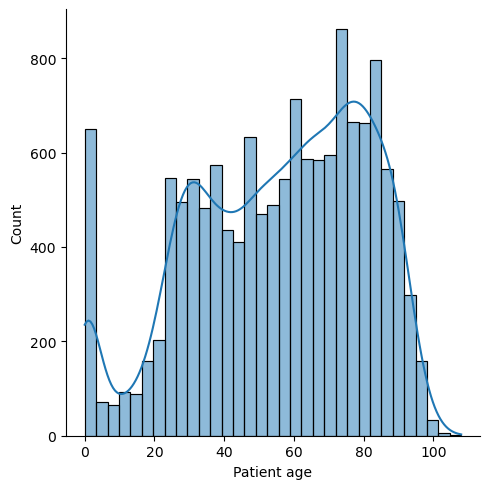

In [16]:
sns.displot(final_df["Patient age"], kde=True)
plt.show()

In [19]:
import scipy.stats as st
import numpy as np

def _to_proba(preds):
    
    if isinstance(preds, dict):
        if 'response_mean' in preds:
            return preds['response_mean']
        else:
            raise KeyError(f"'response_mean' key not found in prediction dict. Keys available: {list(preds.keys())}")
    else:
        return st.norm.cdf(preds)


In [20]:
from sklearn.metrics import roc_auc_score, brier_score_loss, average_precision_score
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import gpboost as gpb

drop_cols = [
    'strain', 'category',
    'country_encoded', 'region_encoded', 'country', 'region',
    'Collection date', 'month', 'age_band', '__stratum__', 'ipi_weight'
]
drop_cols = [c for c in drop_cols if c in final_df.columns]

fixed_effects = final_df.drop(columns=drop_cols)        
target        = final_df['category'].values            


groups  = final_df[['country_encoded','region_encoded']].values  

weights = final_df['ipi_weight'].values

X = fixed_effects.values
y = target

params = {
    "objective": "binary",
    "learning_rate": 0.05,
    "num_leaves": 31
}

def expected_calibration_error(y_true, y_prob, n_bins=10, sample_weight=None):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    if sample_weight is None:
        sample_weight = np.ones_like(y_true, dtype=float)

    for i in range(n_bins):
        bin_mask = (y_prob >= bins[i]) & (y_prob < bins[i + 1])
        bin_size = np.sum(sample_weight[bin_mask])
        if bin_size > 0:
            bin_acc = np.average(y_true[bin_mask], weights=sample_weight[bin_mask])
            bin_conf = np.average(y_prob[bin_mask], weights=sample_weight[bin_mask])
            ece += (bin_size / np.sum(sample_weight)) * abs(bin_acc - bin_conf)
    return ece

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rows = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    X_tr, X_va = X[train_idx], X[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]
    g_tr, g_va = groups[train_idx], groups[val_idx]
    w_tr, w_va = weights[train_idx], weights[val_idx]

    gp_model = gpb.GPModel(group_data=g_tr, likelihood="bernoulli_probit")
    d_train  = gpb.Dataset(data=X_tr, label=y_tr)  # no weights passed
    m_boost  = gpb.train(params=params, train_set=d_train, gp_model=gp_model, num_boost_round=2000)

    
    p_val = _to_proba(m_boost.predict(data=X_va, group_data_pred=g_va))

    cv_rows.append({
        "Fold": fold,
        "Setting": "Unweighted",
        "AUROC": roc_auc_score(y_va, p_val),
        "AUPRC": average_precision_score(y_va, p_val),
        "Brier": brier_score_loss(y_va, p_val),
        "ECE@10": expected_calibration_error(y_va, p_val, n_bins=10),
    })

    cv_rows.append({
        "Fold": fold,
        "Setting": "Weighted",
        "AUROC": roc_auc_score(y_va, p_val, sample_weight=w_va),
        "AUPRC": average_precision_score(y_va, p_val, sample_weight=w_va),
        "Brier": brier_score_loss(y_va, p_val, sample_weight=w_va),
        "ECE@10": expected_calibration_error(y_va, p_val, n_bins=10, sample_weight=w_va),
    })

cv_results = pd.DataFrame(cv_rows)

summary = cv_results.groupby("Setting").agg(["mean", "std"]).round(4)

print("Per-fold results:\n", cv_results)
print("\nSummary (mean ± std across folds):\n", summary)


[GPBoost] [Info] Total Bins 33447
[GPBoost] [Info] Number of data points in the train set: 11178, number of used features: 16663
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.048791
[GPBoost] [Info] Start training from score 2.048791
[GPBoost] [Info] Total Bins 33429
[GPBoost] [Info] Number of data points in the train set: 11178, number of used features: 16654
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.107844
[GPBoost] [Info] Start training from score 2.107844
[GPBoost] [Info] Total Bins 33514
[GPBoost] [Info] Number of data points in the train set: 11178, number of used features: 16697
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.087266
[GPBoost] [Info] Start training from score 2.087266
[GPBoost] [Info] Total Bins 33353
[GPBoost] [Info] Number of data points in the train set: 11179, number of used features: 16616
[GPBoost] [Info] [GPBoost with bernoulli_probit likelihood]: initscore=2.118517
[GPBoost

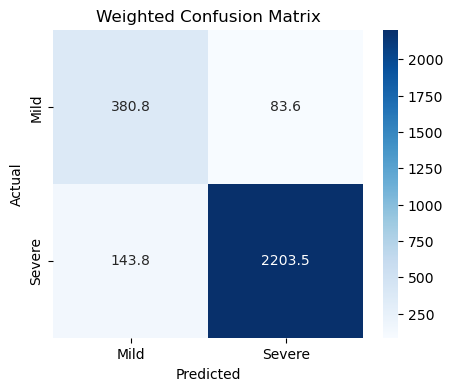


Classification Report (weighted):

              precision    recall  f1-score   support

        Mild     0.7258    0.8199    0.7700 464.45938427742186
      Severe     0.9634    0.9387    0.9509 2347.3843022242663

    accuracy                         0.9191 2811.8436865016884
   macro avg     0.8446    0.8793    0.8605 2811.8436865016884
weighted avg     0.9242    0.9191    0.9210 2811.8436865016884

fpr = [0.         0.         0.         ... 0.99928962 0.9995095  1.        ]
tpr = [0.         0.00220793 0.00397428 ... 1.         1.         1.        ]
thresholds = [           inf 9.99999794e-01 9.99999730e-01 ... 5.08443902e-04
 4.04755837e-04 1.43549744e-04]
AUC (weighted) = 0.965


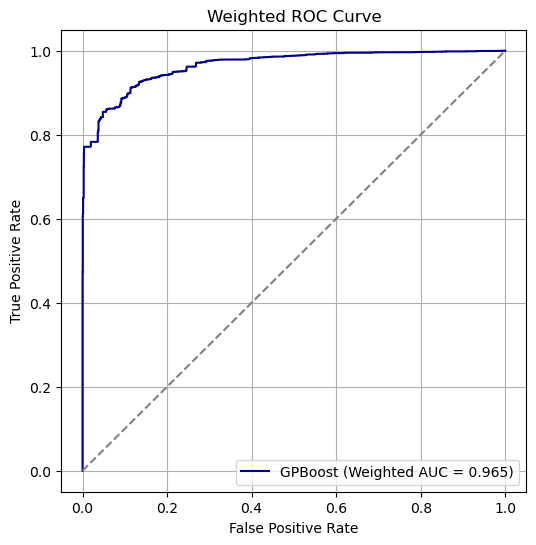

In [21]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (p_val >= 0.5).astype(int)

cm = confusion_matrix(y_va, y_pred, sample_weight=w_va)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=['Mild', 'Severe'],
            yticklabels=['Mild', 'Severe'])
plt.title("Weighted Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report (weighted):\n")
print(classification_report(
    y_va, y_pred,
    target_names=["Mild", "Severe"],
    sample_weight=w_va,
    digits=4
))

fpr, tpr, thresholds = roc_curve(y_va, p_val, sample_weight=w_va)
auc_score = roc_auc_score(y_va, p_val, sample_weight=w_va)

print('fpr =', fpr)
print('tpr =', tpr)
print('thresholds =', thresholds)
print(f"AUC (weighted) = {auc_score:.3f}")

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"GPBoost (Weighted AUC = {auc_score:.3f})", color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)

plt.savefig('roc_curve_gpboost_weighted.tiff', dpi=600, format='tiff')
plt.show()


In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)

fpr, tpr, thresholds = roc_curve(y_va, p_val, sample_weight=w_va)
auc_score = roc_auc_score(y_va, p_val, sample_weight=w_va)

print("\n--- ROC Curve Results (Weighted) ---")
print("False Positive Rates (FPR):\n", fpr)
print("True Positive Rates (TPR):\n", tpr)
print("Thresholds:\n", thresholds)
print(f"Weighted AUC = {auc_score:.3f}")

roc_df = pd.DataFrame({
    "FPR": fpr,
    "TPR": tpr,
    "Threshold": thresholds
})
roc_df.to_csv("roc_curve_values_gpboostmixedweighted.csv", index=False)
print("\nROC curve values saved to: roc_curve_values_weighted.csv")




--- ROC Curve Results (Weighted) ---
False Positive Rates (FPR):
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.